Hi David,

The recollection of this morning's discussion:

Right now, you compute, for each crosscorrelation, an initial estimate of the combined timing error by crosscorrelating the first crosscorrelation with the last crosscorrelation. That is, even if there would not be a single interferometric surface wave response (not a high peak) in that crosscorrelation. 

In order to prevent this, we should first estimate the SNR of the causal and acausal peaks. You can call my routine for this, with the initial timing error estimate set to zero. For each station couple, you subsequently determine which crosscorrelations (i.e., associated with different crosscorrelation periods) have at least one of these peaks exceeding the SNR threshold. For each station couple, you then compute (from the crosscorrelations that remain) an initial drift rate based on the crosscorrelation of the first and last crosscorrelation. If there is only crosscorrelation for a station couple (i.e., only for a single time), you can of course not do this. All in all, this should, to some extend, prevent "bad" initial timing errors.

After you have the initial drift rates, you can use those to compute the data vector (i.e., the T_{app}) for solving the inverse problem. The conditions (SNR threshold, station separation, minimum number of crosscorrelations, etc.) of course need to be fulfilled. This data vector (and associated matrix a) can be used to invert for a first set of a's and b's. Note that you do not include the crosscorrelations in this first inversion for which you did not determine an initial drift rate.


 
In summary, the workflow/approach:
 

 
1. Set the following parameters:
1. a. SNR threshold
1. b. Minimum station separation
1. c. Minimum number of crosscorrelations
1. d. Minimum number of connections
1. e. Minimum number of crosscorrelation periods
1. f. Minimum separation in days
2. Compute causal and acausal SNR's, and station-station distances for all station couples.
3. Compute drift rates using the first and last crosscorrelation of a station couple (both these crosscorrelations should have one peak that exceeds the SNR threshold; see above)
4. Including only those station couples that fulfill the set conditions, and for which drift rates have been estimated, solve the inverse problem for the first time. You use the drift rates to estimate the expected timing errors for each of the crosscorrelations.
5. Use the obtained a's and b's to compute estimates of each crosscorrelation's time shift and again solve the invers problem (2nd iteration). In this case, you use all crosscorrelations that fulfil the conditions. 
6. Iterate a few times, until a's and b's are stable. 
7. Apply bootstrapping (use 1000 realizations) using an ordinary least squares approach, and weighted least squares approach. For all realizations, make sure the conditions are fulfilled. This will mean that number of rows and number of estimated a's and b's (i.e., number of stations) may vary between realizations
8. For each individual station, compute a minus the average a. That is, the average over 1000 (or a few less) realizations.
9. Make a histogram using all realizations and all stations (maximum 1000 x # of stations; in practice a bit less).
10. Do the same for the b values.
11. Fit a gaussian to the histograms, and determine the standard deviation (or variance). Note that you now again have to compute the average a and b, as the number of stations per realizations may vary.

Investigating dependency on different sets of parameters:

The workflow above, you should execute for different combinations of parameters. I propose the following two variations for the crosscorrelation conditions.

1. Minimum number of crosscorrelations for a station = 3, Minimum number of connections for a station = 2, Minimum number of crosscorrelation periods for a station = 2, minimum number of separation in days for a station's first and last crosscorrelation = 30 (this does not need to be with the same other station).
2. Minimum number of crosscorrelations for a station = 5, Minimum number of connections for a station = 3, Minimum number of crosscorrelation periods for a station = 3, minimum number of separation in days for a station's first and last crosscorrelation = 30 (this does not need to be with the same other station)

I propose you vary SNR between:
10
20
30
40
50
60

I propose you vary station-station separation threshold between:
1.5
2.0
2.5
3.0
3.5
4.0

The above means that you will execute the bootstrapping 2 x 6 x 6 = 72 times. Simply run it, and evaluate the results. Without bothering too much about the outcome. We will discuss the results coming Tuesday. We can then also decide for which specific combination we will do the bootstrapping again, but this time using SNR as weighting factor. After that, we are done in my opinion.

If things are unclear, please let me know!


In [11]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Jun 10 14:14:04 2022

@author: davidnaranjo
"""
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
# Importing the m importlibain code.
module_path = os.path.abspath('/Users/localadmin/Dropbox/GitHub/ocloc/src/ocloc')

if module_path not in sys.path:
    sys.path.append(module_path)
import ocloc
from ocloc import ProcessingParameters, ClockDrift, trim_correlation_trace, suppress_stdout
import pickle
from statistics import mean
# Parameters for locating the files where the correlation files and station 
# information is contained.
path2data_dir = "/Users/localadmin/Dropbox/GitHub/data"
# path2data_dir = "/Users/localadmin/Dropbox/GitHub/ocloc/tutorials/correlations_O20"
# station_file = "/Users/localadmin/Dropbox/GitHub/ocloc/tutorials/station_info"
station_file = "/Users/localadmin/Dropbox/GitHub/ocloc/tutorials/metadata/station_file.txt"

reference_time = '2014-08-21T00:00:00.000000Z'

In [ ]:
remove

In [35]:
params = ProcessingParameters(
    freqmin=0.2,   # Low freq. for the bandpass filter
    freqmax=0.4,   # High freq. for the bandpass filter 
    ref_vel=2500,  # m/s
    dist_trh=2.5,  # Minimum station separation in terms of wavelength
    snr_trh=35    # Signal-to-noise ratio threshold
    )

cd = ClockDrift(station_file, path2data_dir, 
                reference_time=reference_time,
                list_of_processing_parameters=[params])
with suppress_stdout():
    cd.calculate_aprioridt_4_allcorrelations()
    cd.calculate_dt_ins()
    cd.calculate_tapp_4_allcorrelations()



No correlation file found for station:#STK


In [36]:
cd.filter_stations()
cd.build_matrices()

In [42]:
from ocloc import *
def solve_eq(self, method="lstsq", rcond=None):
    """
    It inverts the matrix and creates a dataframe containing the
    stations with solutions.

    If after the inversion some stations didnt have a solution (e.g
    insufficient cross-correlations) it will assign a correction of zero.
    Meaning than in the worst case scenario the data will stay the same as
    at the beginning.

    params
    -------
    method:
        Can be "lstsq" for performing a least-squares inversion.
        Or "weighted_lstsq" for doing a weighted least-squares
        inversion. The weighting is done based on the station separation.


    Returns
    -------
    None.
    But the results are saved within the Clock_Drift object.
    The a's and b's for each station are now stored in the
    corresponding station objects.

    """
    try:
        A_dum = self.matrix_A.copy()
        Tobs_dum = self.df["t_app[s]"].copy()
    except BaseException:
        self.build_matrices()
        A_dum = self.matrix_A.copy()
        Tobs_dum = self.df["t_app[s]"].copy()

    if method == "lstsq":
        print("Calculating a and b for each station.")
        x, _, rank, _, = np.linalg.lstsq(A_dum, Tobs_dum, rcond=rcond)

    elif method == "weighted_lstsq":
        print("Calculating a and b for each station.")
        print("The weighting is done based on the station separation.")

        # Now we define the data weighting vector W
        W = []

        for i in range(len(self.matrix_A.index)):
            station1_code = self.matrix_A.index[i].split("_")[0]
            station2_code = self.matrix_A.index[i].split("_")[1]
            station1 = self.get_station(station1_code)
            station2 = self.get_station(station2_code)
            # Station separation.
            # Great circle distance in m using WGS84 ellipsoid.
            cpl_dist = gps2dist_azimuth(
                station1.latitude,
                station1.longitude,
                station2.latitude,
                station2.longitude,
            )[0]
            W.append(cpl_dist)
        W = np.array(W)

        A_dum = self.matrix_A
        Tobs_dum = self.df["t_app[s]"].copy()

        # Aw = np.dot(W, A_dum) # * np.sqrt(W[:,np.newaxis])
        # Bw = np.dot(W, Tobs_dum) # * np.sqrt(W)
        
        # Normalize.
        W = W / max(W)
        
        W = np.diag(W)
        Aw = W @ A_dum
        Bw = Tobs_dum @ W 
        x, _, rank, _, = np.linalg.lstsq(Aw, Bw, rcond=rcond)
    else:
        msg = "You have to choose an inversion method that can be 'lstsq'"
        msg += "for least squares inversion or 'weighted_lstsq' for "
        msg += "weighted least squares inversion."
        raise Exception(msg)
    column_names = []
    for i in self.matrix_A.columns:
        column_names.append(i.replace("*t_{N_lps}", ""))
    sol = pd.DataFrame(columns=column_names)
    sol.loc["values"] = x

    # This list will be used to verify that all stations have solutions.
    stations_with_solutions = []
    for value, header in zip(x, column_names):
        if "a" in header:
            station_code = header.replace("a (", "").replace(")", "")
            stations_with_solutions.append(station_code)
            station = self.get_station(station_code)
            station.a.append(value)
            continue
        if "b" in header:
            station_code = header.replace("b (", "").replace(")", "")
            station = self.get_station(station_code)
            station.b.append(value)
    self.solution = sol
    self.iteration += 1

    # Make the correction be equal to zero for stations without
    # measurements.
    for station in self.stations:
        if station.needs_correction:
            if station.code not in stations_with_solutions:
                station.a.append(0)
                station.b.append(0)

Calculating a and b for each station.
The weighting is done based on the station separation.
Calculating a and b for each station.
The weighting is done based on the station separation.
Calculating a and b for each station.
The weighting is done based on the station separation.
Calculating a and b for each station.
The weighting is done based on the station separation.


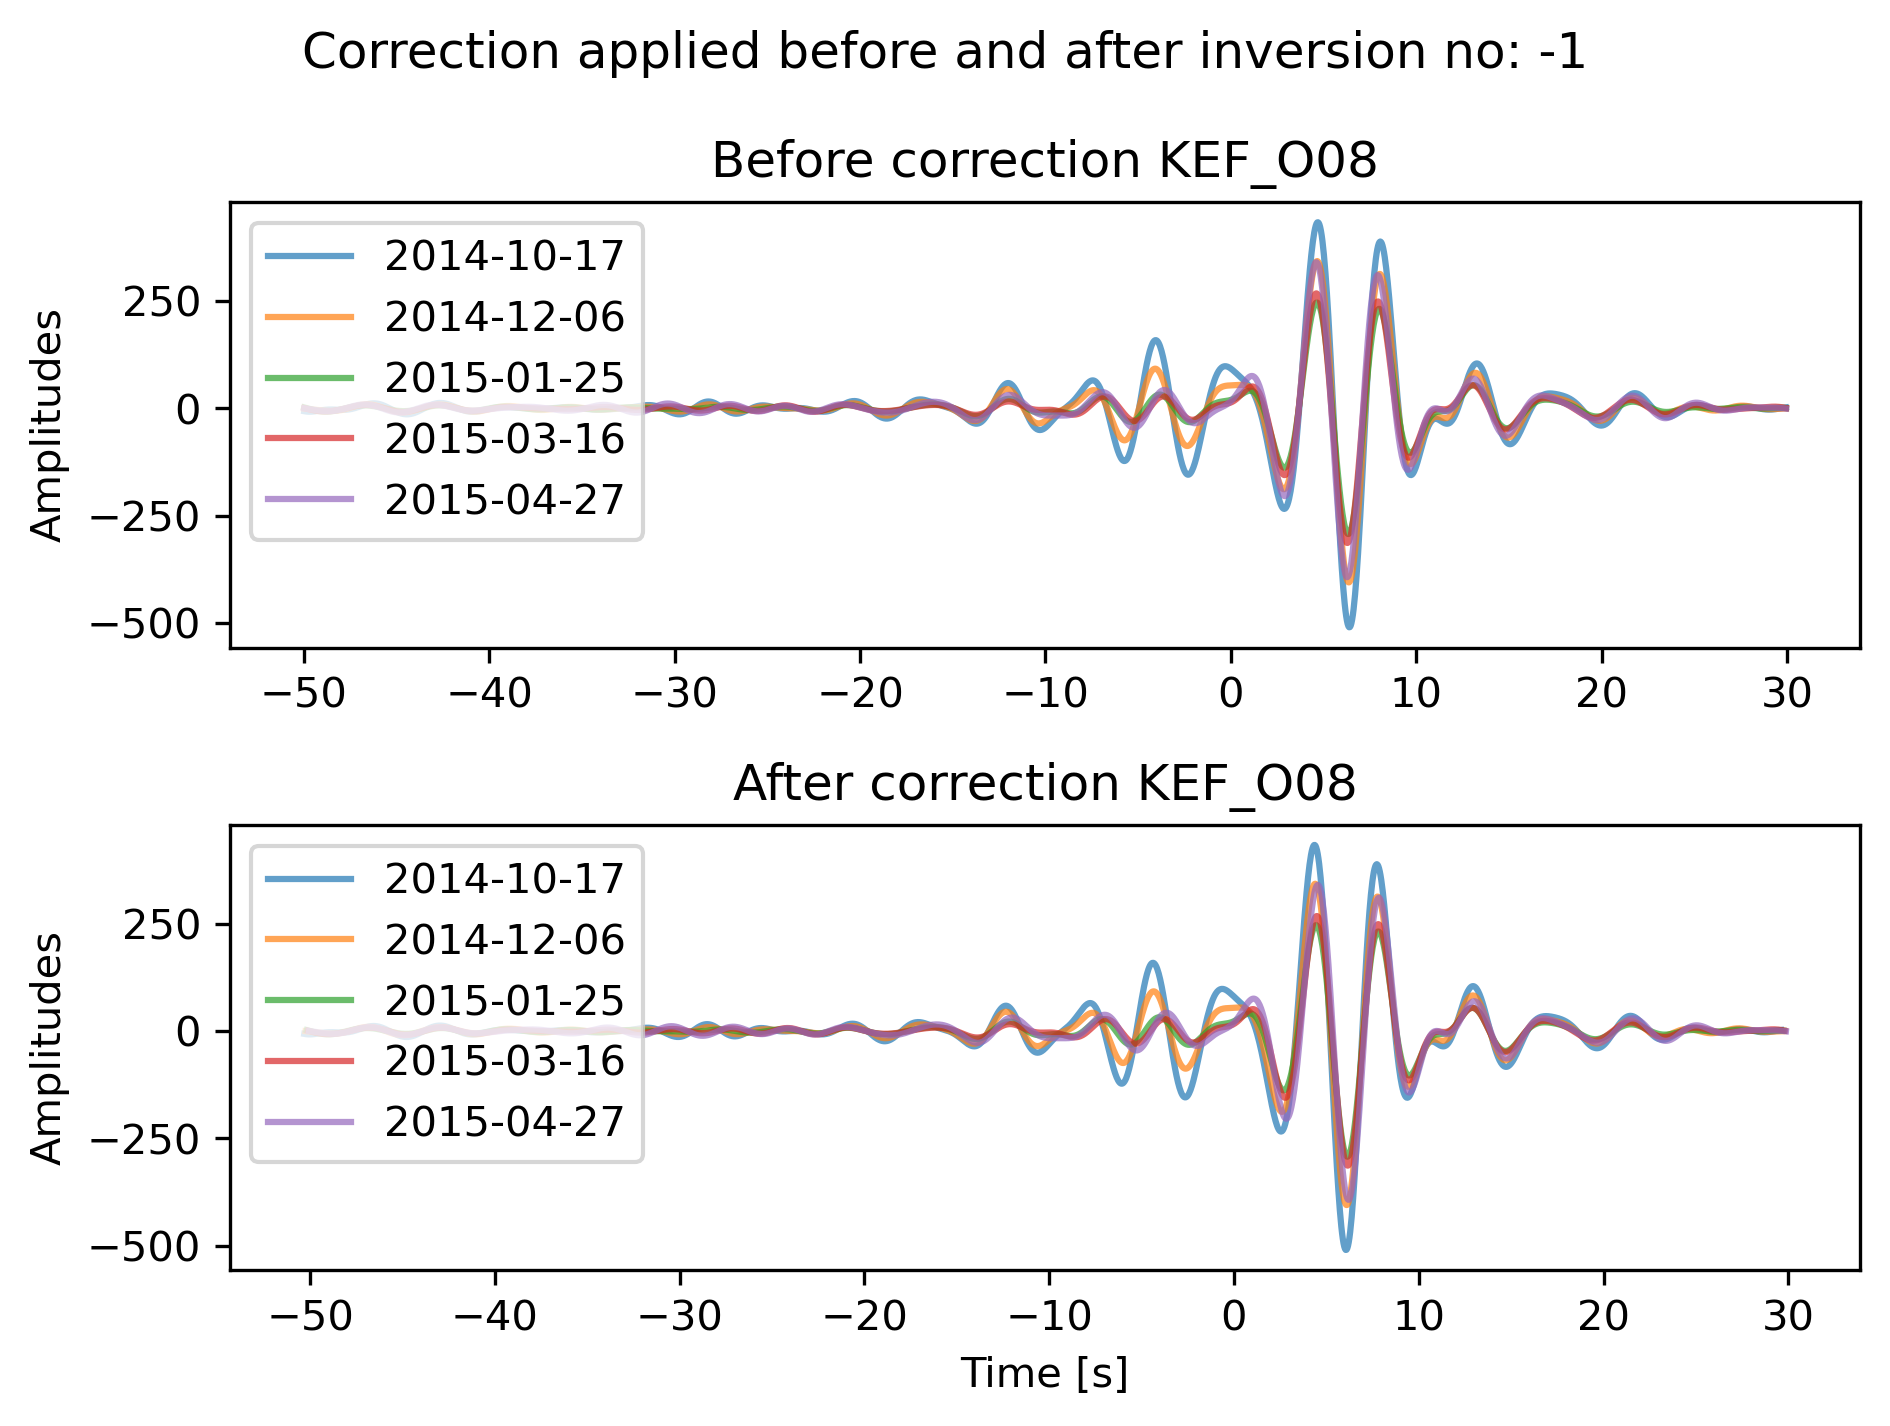

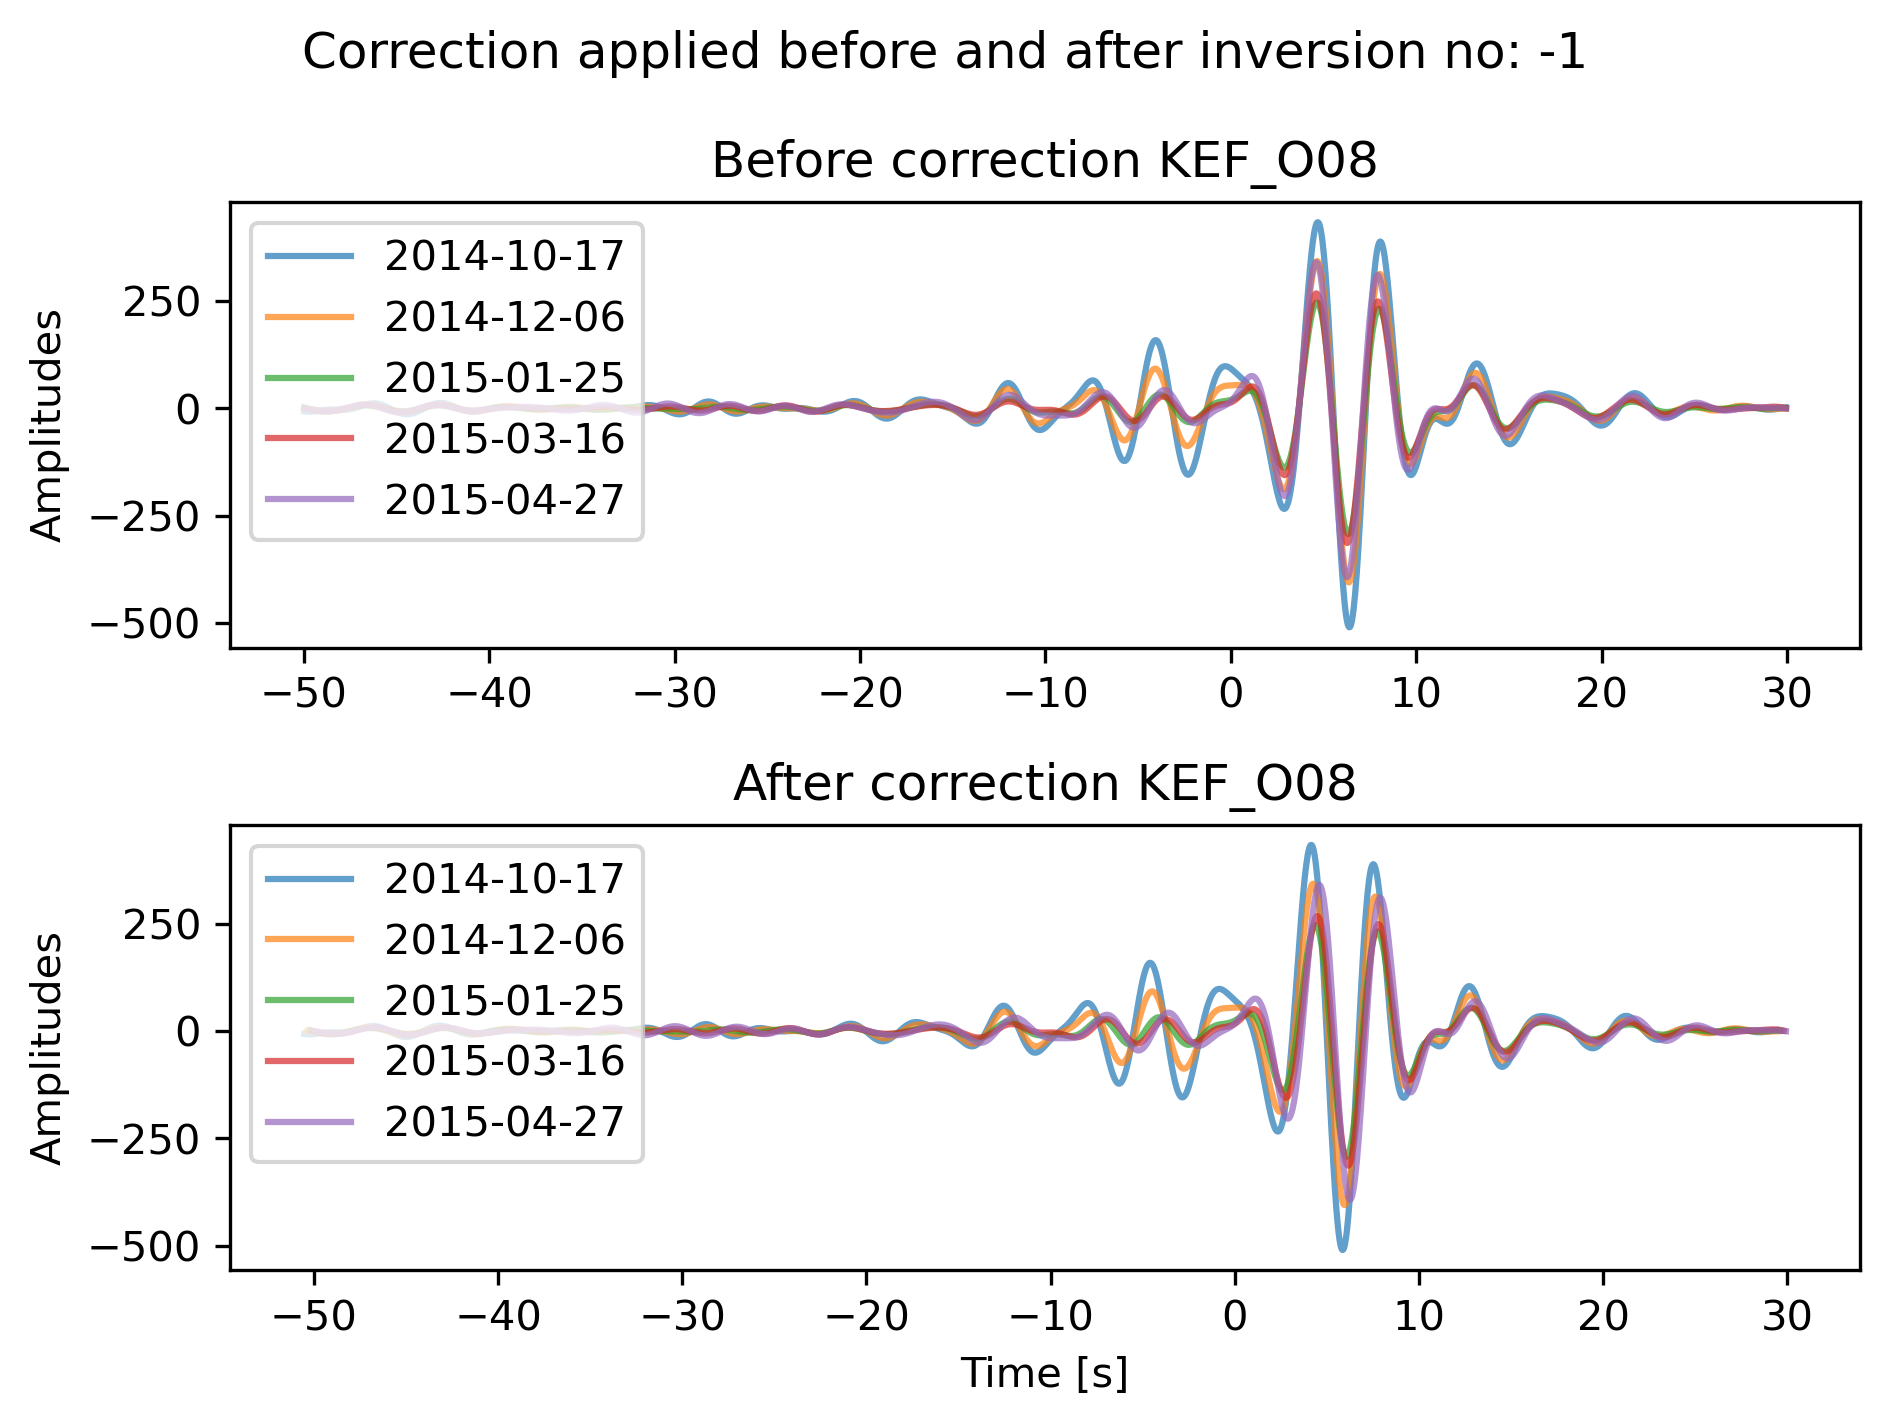

In [43]:
cd_w = cd.copy()
cd_l = cd.copy()

for i in range(2):
    solve_eq(cd_w, method="weighted_lstsq")
    cd_l.solve_eq(method="weighted_lstsq")

cd_w.plot_correlation_beforeNafter_correction("O08", "KEF")
cd_l.plot_correlation_beforeNafter_correction("O08", "KEF")

In [ ]:
remove until here

# Investigating dependency on different sets of parameters:

1. min_number_of_total_correlations=3
2. min_number_correlation_periods=2
3. min_number_of_stationconnections=2
4. days_apart=30

In [2]:
min_number_of_total_correlations=3
min_number_correlation_periods=2
min_number_of_stationconnections=2
days_apart=30

In [3]:
import ocloc
import importlib
importlib.reload(ocloc)

<module 'ocloc' from '/Users/localadmin/Dropbox/GitHub/ocloc/src/ocloc/ocloc.py'>

### Varying SNR and dist_trh

In [7]:
def solve_inverse(dist_trh, snr_trh):
    """
    Fuinction to calculate the a's and b's of a station using
    different dist_trh and snr_trh.
    
    Returns ClockDrift object which save everything needed.
    """
    params = ProcessingParameters(
        freqmin=0.2,   # Low freq. for the bandpass filter
        freqmax=0.4,   # High freq. for the bandpass filter 
        ref_vel=2500,  # m/s
        dist_trh=dist_trh,  # Minimum station separation in terms of wavelength
        snr_trh=snr_trh    # Signal-to-noise ratio threshold
        )

    cd = ClockDrift(station_file, path2data_dir, 
                    reference_time=reference_time,
                    list_of_processing_parameters=[params])
    with suppress_stdout():
        cd.calculate_aprioridt_4_allcorrelations()
        cd.calculate_dt_ins()
        cd.calculate_tapp_4_allcorrelations()

        for i in range(3):
            cd.filter_stations()
            cd.build_matrices()
            cd.solve_eq(method="weighted_lstsq")
            cd.calculate_dt_ins()
            cd.calculate_tapp_4_allcorrelations()

    # Make a few plots
    plt.show()
    print("snr : " + str(snr_trh) + "\n distance threshold: " + str(dist_trh))
    #cd.plot_matrix_diff_observed_predicted()
    #cd.plot_fluctuation_of_a_and_b()
    #cd.plot_observed_vs_predicted()
    return cd


In [8]:
def bootstrap_cd(cd):
    """
    Method to bootstrap the t_app values and return a new
    ClockDrift object with the bootstrapped values called
    bootstrapped_cd
    """
    bootstrapped_cd = cd.copy()
    correlations_with_tapp = []
    for c in bootstrapped_cd.correlations:
        if not np.isnan(c.t_app[-1]):
            correlations_with_tapp.append(c)
    index_list = np.random.choice(range(len(correlations_with_tapp)),
                                  replace=True,
                                  size=len(correlations_with_tapp))

    res_list = [correlations_with_tapp[i] for i in index_list]
    bootstrapped_cd.correlations = res_list
    return bootstrapped_cd

# a - mean(a_same_iteration)

In [10]:
results = {}
for snr_trh in [10, 20, 30, 40, 50, 60]:
    for dist_trh in [1.5, 2.0, 2.5, 3.0, 3.5, 4.0]:
        iteration = "snr_trh:" + str(snr_trh) + " dist_trh:" + str(dist_trh)
        results["weighted a " + iteration] = []
        results["weighted b " + iteration] = []
        results["lstsq a " + iteration] = []
        results["lstsq b " + iteration] = []

        cd = solve_inverse(dist_trh, snr_trh)

        initial_a_values = [sta.a[-1] for sta in cd.stations if sta.needs_correction]
        initial_b_values = [sta.b[-1] for sta in cd.stations if sta.needs_correction]
        initial_mean_a = mean(initial_a_values)
        initial_mean_b = mean(initial_b_values)
        for ii in range(1000):
            bootstrapped_cd = bootstrap_cd(cd)

            with suppress_stdout():
                a = bootstrapped_cd.filter_stations(min_number_of_total_correlations,
                                                    min_number_correlation_periods, 
                                                    min_number_of_stationconnections,
                                                    days_apart)

                bootstrapped_cd.calculate_dt_ins()
                bootstrapped_cd.build_matrices()

                weighted_cd = bootstrapped_cd.copy()
                weighted_cd.solve_eq(method='weighted_lstsq')

                lstsq_cd = bootstrapped_cd.copy()
                lstsq_cd.solve_eq(method='lstsq')

            a_vals_weighted = [sta.a[-1] for sta in weighted_cd.stations if sta.needs_correction]
            b_vals_weighted = [sta.b[-1] for sta in weighted_cd.stations if sta.needs_correction]
            a_vals_weighted_minus_init_mean = [a - mean(a_vals_weighted) for a in a_vals_weighted]
            b_vals_weighted_minus_init_mean = [b - mean(b_vals_weighted) for b in b_vals_weighted]

            a_vals_lstsq = [sta.a[-1] for sta in lstsq_cd.stations if sta.needs_correction]
            b_vals_lstsq = [sta.b[-1] for sta in lstsq_cd.stations if sta.needs_correction]
            a_vals_lstsq_minus_init_mean = [a - mean(a_vals_lstsq) for a in a_vals_lstsq]
            b_vals_lstsq_minus_init_mean = [b - mean(b_vals_lstsq) for b in b_vals_lstsq]

            for a_w, b_w, a_l, b_l in zip(a_vals_weighted_minus_init_mean,
                                         b_vals_weighted_minus_init_mean,
                                         a_vals_lstsq_minus_init_mean,
                                         b_vals_lstsq_minus_init_mean):
                results["weighted a " + iteration].append(a_w)
                results["weighted b " + iteration].append(b_w)
                results["lstsq a " + iteration].append(a_l)
                results["lstsq b " + iteration].append(b_l)
        f = open("bootstrap_a_minuus_mean_a_same_iteration.pkl", "wb")
        pickle.dump(results, f)
        f.close()

No correlation file found for station:#STK
snr : 10
 distance threshold: 1.5
No correlation file found for station:#STK
snr : 10
 distance threshold: 2.0
No correlation file found for station:#STK
snr : 10
 distance threshold: 2.5
No correlation file found for station:#STK
snr : 10
 distance threshold: 3.0
No correlation file found for station:#STK
snr : 10
 distance threshold: 3.5
No correlation file found for station:#STK
snr : 10
 distance threshold: 4.0
No correlation file found for station:#STK
snr : 20
 distance threshold: 1.5
No correlation file found for station:#STK
snr : 20
 distance threshold: 2.0
No correlation file found for station:#STK
snr : 20
 distance threshold: 2.5
No correlation file found for station:#STK


KeyboardInterrupt: 

# Bootstrap a - mean(initial(a_values))

# Bootstrapping

1. Solve the inverse problem until getting stable inversion of a's and b's.
2. Save the mean value of the a's and b's ($a_{mean}^0$, $b_{mean}^0$).
3. Bootstrapp the t_app measurements allowing repetition.
4. Solve the inverse problem which provides a new set of a's and b's.
5. Compute for each station $a-a_{mean}^0$ and $b-b_{mean}^0$ and add these values to a histogram.


In [ ]:
for snr_trh in [10, 20, 30, 40, 50, 60]:
    for dist_trh in [1.5, 2.0, 2.5, 3.0, 3.5, 4.0]:
        iteration = "snr_trh:" + str(snr_trh) + " dist_trh:" + str(dist_trh)
        for inverse_method in ["weighted a ",
                              "weighted b ",
                              "lstsq a ",
                              "lstsq b "]:
            title = inverse_method + iteration
            values = results[title]

            plt.hist(values, bins = 50,
                    alpha=0.5,
                    facecolor="C1",
                    edgecolor="black",
                    linewidth=1
                    )
            plt.title(title)
            plt.xlabel("Value - mean(initial_value)")
            plt.ylabel("Counts")
            # plt.xlim(-0.005, 0)
            # plt.ylim(0, 80)
            plt.show()

1. Minimum number of crosscorrelations for a station = 5
2. Minimum number of connections for a station = 3
3. Minimum number of crosscorrelation periods for a station = 3
4. minimum number of separation in days for a station's first and last crosscorrelation = 30

In [ ]:
min_number_of_total_correlations=5
min_number_correlation_periods=3
min_number_of_stationconnections=3
days_apart=30